In [18]:
import numpy as np,pandas as pd,seaborn as sns,matplotlib.pyplot as plt

## Basic info

- survival	Survival	0 = No, 1 = Yes
- pclass	    Ticket class	1 = 1st, 2 = 2nd, 3 = 3rd
- sex	        Sex	
- Age	        Age in years	
- sibsp	    # of siblings / spouses aboard the Titanic	
- parch	    # of parents / children aboard the Titanic	
- ticket	    Ticket number	
- fare	    Passenger fare	
- cabin	    Cabin number	
- embarked	Port of Embarkation	C = Cherbourg, Q = Queenstown, S = Southampton

for age 
- Mr. (for men of all the ages)

- Miss. (for women not married, so mainly child and young women)

- Mrs. (for married women, so with an higher average age)

- Master. (for male children, an old form of invitation, not used anymore)

- Other like Rev., Col. Sir. Dr.  etc... that I have called "Professional", mainly male and with an high age.

In [19]:
df = pd.read_csv('train.csv')

In [20]:
df_test = pd.read_csv('test.csv')

# Feature engineering for training data 

In [21]:
def null_plot(df):
    df_null = (100 * df.isnull().sum() / len(df))
    df_null = df_null[df_null > 0].sort_values()
    sns.barplot(x=df_null.index, y=df_null)
    plt.xticks(rotation=90)
    plt.ylabel('null percentage')

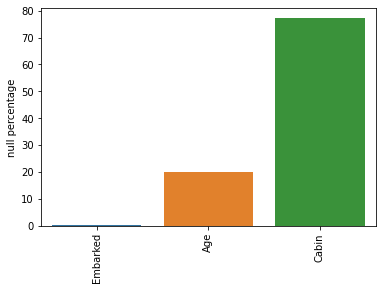

In [22]:
null_plot(df)

In [23]:
df.at[61,'Embarked'] = 'S'
df.at[829,'Embarked'] = 'S'

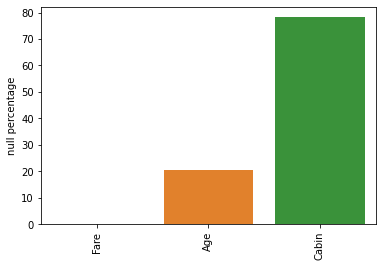

In [24]:
null_plot(df_test)

In [25]:
fare = df[(df['Pclass'] == 3) & (df['Age'] > 58)]['Fare'].median()
df_test.at[152,'Fare'] = fare

In [26]:
df.drop('Cabin',axis=1,inplace=True)
df_test.drop('Cabin',axis=1,inplace=True)

### Age missing values

In [27]:
import re

In [28]:
all_data=[df,df_test]

In [14]:
def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    # If the title exists, extract and return it.
    if title_search:
        return title_search.group(1)
    return ""

In [16]:
for dataset in all_data:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1

In [31]:
for dataset in all_data:
    dataset['Title'] = dataset['Name'].apply(get_title)

In [35]:
for dataset in all_data:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 
                                                 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

### Fill age NaN values

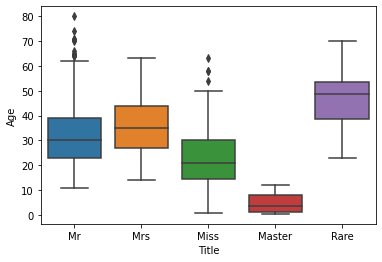

In [38]:
sns.boxplot(x='Title',y='Age',data=all_data[0]);

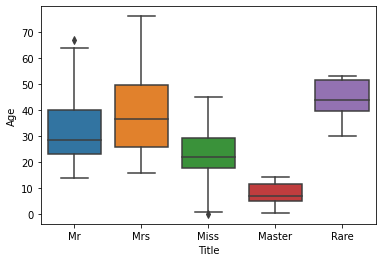

In [40]:
sns.boxplot(x='Title',y='Age',data=all_data[1]);

In [42]:
df_con = pd.concat([df['Age'],df['Title']],axis=1)
df_test_con = pd.concat([df_test['Age'],df_test['Title']],axis=1)

In [47]:
all_age = pd.concat([df_con,df_test_con],axis=0)

In [49]:
all_age['Title'].value_counts()

Mr        757
Miss      264
Mrs       198
Master     61
Rare       29
Name: Title, dtype: int64

In [54]:
Mr_age = all_age[all_age['Title'] == 'Mr']['Age'].median()
Miss_age = all_age[all_age['Title'] == 'Miss']['Age'].median()
Mrs_age = all_age[all_age['Title'] == 'Mrs']['Age'].median()
Master_age = all_age[all_age['Title'] == 'Master']['Age'].median()
Rare_age = all_age[all_age['Title'] == 'Rare']['Age'].median()

In [57]:
def fill_age(n,age):
    if np.isnan(age):
        if n == 'Mr':
            return Mr_age
        elif n == 'Mrs':
            return Mrs_age
        elif n == 'Miss':
            return Miss_age
        elif n == 'Master':
            return Master_age
        else:
            return Rare_age
    else:
        return age

In [68]:
# Assign null values to age
for dataset in all_data:
    dataset['Age'] = np.vectorize(fill_age)(dataset['Title'],dataset['Age'])

## At this point, no missing values

In [88]:
## create bin for age features
for dataset in all_data:
    dataset['Age_bin'] = pd.cut(dataset['Age'], bins=[0,12,20,40,120], labels=['Children','Teenage','Adult','Elder'])

In [89]:
## create bin for fare features
for dataset in all_data:
    dataset['Fare_bin'] = pd.cut(dataset['Fare'], bins=[0,7.91,14.45,31,120], labels=['Low_fare','median_fare',
                                                                                      'Average_fare','high_fare'])

In [92]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   PassengerId  891 non-null    int64   
 1   Survived     891 non-null    int64   
 2   Pclass       891 non-null    int64   
 3   Name         891 non-null    object  
 4   Sex          891 non-null    object  
 5   Age          891 non-null    float64 
 6   SibSp        891 non-null    int64   
 7   Parch        891 non-null    int64   
 8   Ticket       891 non-null    object  
 9   Fare         891 non-null    float64 
 10  Embarked     891 non-null    object  
 11  Title        891 non-null    object  
 12  Age_bin      891 non-null    category
 13  Fare_bin     838 non-null    category
dtypes: category(2), float64(2), int64(5), object(5)
memory usage: 85.8+ KB


In [93]:
### make copy of dataset for training
traindf = df
finaldf = df_test

In [94]:
all_train = [traindf,finaldf]

In [95]:
for dataset in all_train:
    drop_column = ['Age','Fare','Name','Ticket']
    dataset.drop(drop_column,axis=1,inplace=True)

In [99]:
traindf.drop('PassengerId',axis=1,inplace=True)

## one hot encoding

In [103]:
traindf = pd.get_dummies(traindf, columns = ["Sex","Title","Age_bin","Embarked","Fare_bin"],
                             prefix=["Sex","Title","Age_type","Em_type","Fare_type"])

In [105]:
finaldf = pd.get_dummies(finaldf, columns = ["Sex","Title","Age_bin","Embarked","Fare_bin"],
                             prefix=["Sex","Title","Age_type","Em_type","Fare_type"])

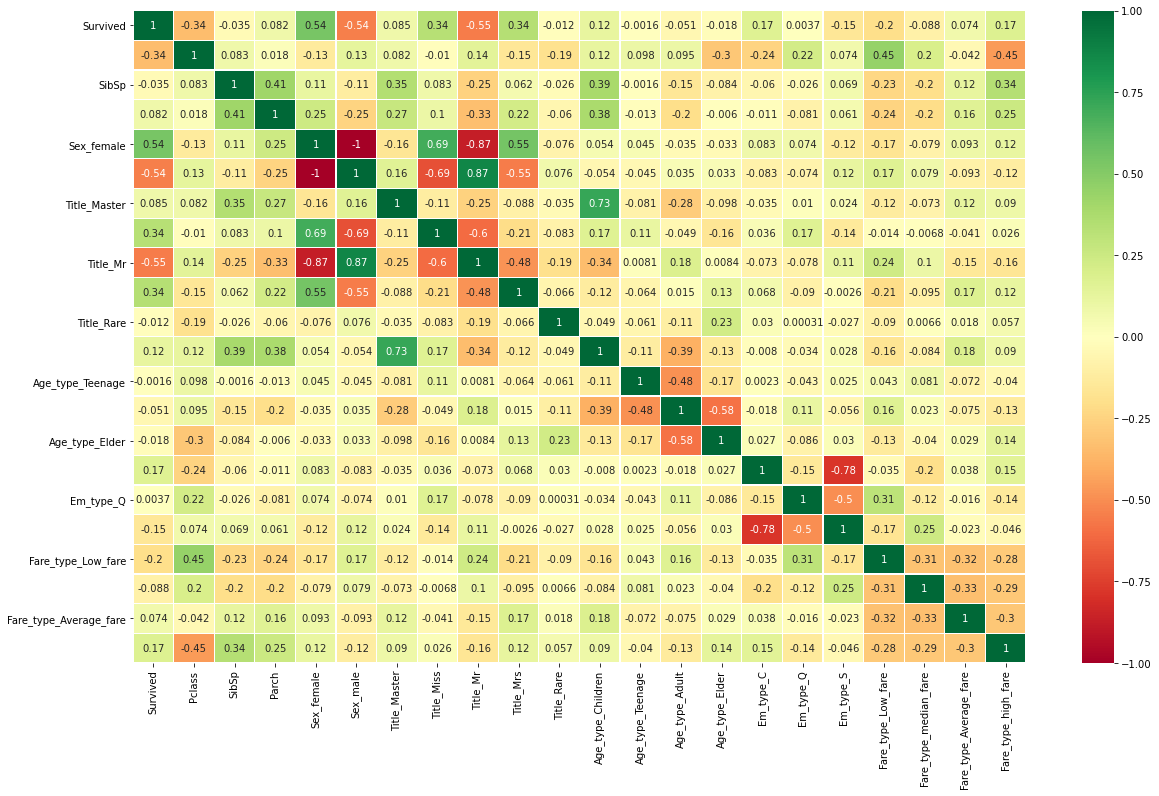

In [109]:
sns.heatmap(traindf.corr(),annot=True,cmap='RdYlGn',linewidths=0.2) #data.corr()-->correlation matrix
fig=plt.gcf()
fig.set_size_inches(20,12)
plt.show()

# Logistic regression

In [126]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix,accuracy_score,classification_report,confusion_matrix

In [116]:
from sklearn.model_selection import KFold #for K-fold cross validation
from sklearn.model_selection import cross_val_score #score evaluation
from sklearn.model_selection import cross_val_predict #prediction

In [115]:
X = traindf.drop('Survived',axis=1)
y = traindf['Survived']

In [118]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

In [117]:
model = LogisticRegression()

In [119]:
model.fit(X_train,y_train)

LogisticRegression()

In [120]:
pred = model.predict(X_test)

In [123]:
print('--------------The Accuracy of the model----------------------------')
print('The accuracy of the Logistic Regression is',round(accuracy_score(pred,y_test)*100,2))

--------------The Accuracy of the model----------------------------
The accuracy of the Logistic Regression is 81.72


In [124]:
kfold = KFold(n_splits=10, random_state=22) # k=10, split the data into 10 equal parts
result_lr=cross_val_score(model,X,y,cv=10,scoring='accuracy')
print('The cross validated score for Logistic REgression is:',round(result_lr.mean()*100,2))

The cross validated score for Logistic REgression is: 82.04


/Users/aristo/opt/anaconda3/envs/DS_Learning/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


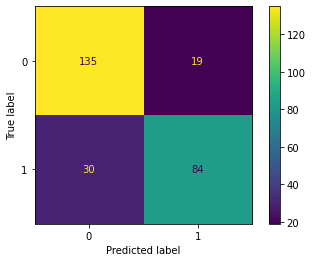

In [129]:
plot_confusion_matrix(model,X_test,y_test)

In [130]:
print(classification_report(pred,y_test))

              precision    recall  f1-score   support

           0       0.88      0.82      0.85       165
           1       0.74      0.82      0.77       103

    accuracy                           0.82       268
   macro avg       0.81      0.82      0.81       268
weighted avg       0.82      0.82      0.82       268



In [138]:
accuracy_score(y_test,pred)

0.8171641791044776

# Random forest

Important features
____________________________________________________________
90.53


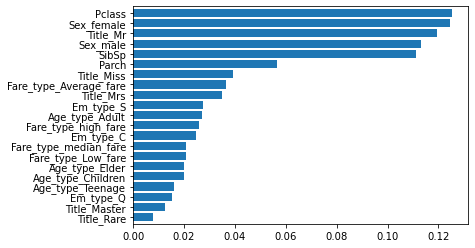

In [133]:
from sklearn.ensemble import RandomForestClassifier
random_forest = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=400, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
random_forest.fit(X_train,y_train)
pred_rf = random_forest.predict(X_test)
random_forest.score(X_train,y_train)
acc_random_forest = round(random_forest.score(X_train, y_train) * 100, 2)

print("Important features")
pd.Series(random_forest.feature_importances_,X_train.columns).sort_values(ascending=True).plot.barh(width=0.8)
print('__'*30)
print(acc_random_forest)

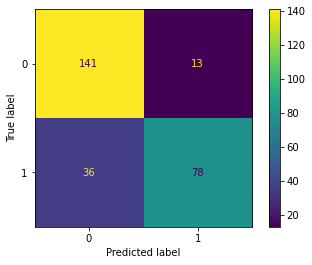

In [134]:
plot_confusion_matrix(random_forest,X_test,y_test)

In [135]:
print(classification_report(pred_rf,y_test))

              precision    recall  f1-score   support

           0       0.92      0.80      0.85       177
           1       0.68      0.86      0.76        91

    accuracy                           0.82       268
   macro avg       0.80      0.83      0.81       268
weighted avg       0.84      0.82      0.82       268



In [139]:
accuracy_score(y_test,pred_rf)

0.8171641791044776

# Final model

In [142]:
final_model = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=400, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [143]:
final_model.fit(X,y)

RandomForestClassifier(n_estimators=400, n_jobs=1)

In [145]:
id = finaldf['PassengerId']
finaldf.drop('PassengerId',axis=1,inplace=True)

In [146]:
res = final_model.predict(finaldf)

In [150]:
submission = pd.DataFrame({'PassengerId':id,'Survived':res})

In [151]:
submission.to_csv('submission3.csv',index=False)